In [117]:
import json
import math
import typing as tp
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime, timedelta

import backoff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import web3
from tqdm.notebook import tqdm
from web3.middleware import geth_poa_middleware

from emulation import Emulation, Position, Vault, get_position_for_usd
from generation import PriceFeed

In [118]:
tokens = ['BTC', 'DAI', 'ETH', 'MATIC', 'USDC', 'USDT', 'stMATIC', 'wstETH']

In [119]:
gas_price = 200 * 1.2 / 10 ** 9 # 200 gwei
gas_amount_for_nfts = [
    937740,
    1377032,
    1978640,
    2482040,
    2932803,
]


gas_amounts = [1377032, 937740, 937740, 937740, 937740, 937740]

In [120]:
with open('config.json', 'r') as file:
    data = json.load(file)

In [121]:
gas_amounts = []

for vault in data['vaults']:
    gas_amounts.append(gas_amount_for_nfts[len(vault['positions'])])
    
liquidation_thresholds = {}

for pair, value in data['liquidation_thresholds'].items():
    token0, token1 = pair.split('/')
    token0 = token0.strip()
    token1 = token1.strip()
    liquidation_thresholds[(token0, token1)] = float(value)

borrow_thresholds = {}

for pair, value in data['borrow_thresholds'].items():
    token0, token1 = pair.split('/')
    token0 = token0.strip()
    token1 = token1.strip()
    borrow_thresholds[(token0, token1)] = float(value)

In [122]:
means = np.load('means.npy')
covariations = np.load('covariations.npy')
starting_values = np.load('starting_values.npy')

In [123]:
vaults: tp.List[Vault] = []

for vault in data['vaults']:
    positions: tp.List[Position] = []
    for position in vault['positions']:
        pair0 = (position['token0'], position['token1'])
        pair1 = (position['token1'], position['token0'])
        liquidation_threshold = liquidation_thresholds.get(pair0) or liquidation_thresholds.get(pair1)
        borrow_threshold = borrow_thresholds.get(pair0) or borrow_thresholds.get(pair1)
        price0 = (
            1.
            if position['token0'] == 'BOB'
            else starting_values[tokens.index(position['token0'])]
        )
        price1 = (
            1.
            if position['token1'] == 'BOB'
            else starting_values[tokens.index(position['token1'])]
        )
        positions.append(
            get_position_for_usd(
                token0=position['token0'],
                token1=position['token1'],
                sqrt_ratio_a=math.sqrt(float(position['left_price'])),
                sqrt_ratio_b=math.sqrt(float(position['right_price'])),
                usd_amount=position['capital'],
                price0=price0,
                price1=price1,
                liquidation_threshold=liquidation_threshold,
                borrow_threshold=borrow_threshold,
            )
        )
    
    vaults.append(Vault(['BOB'] + tokens, positions=positions))
    vaults[-1].debt = float(vault['debt_ratio']) * \
        vaults[-1].calculate_collateral(np.hstack([1, starting_values]).reshape((-1, 1)))[-1][0]

In [124]:
with open('config.json', 'r') as file:
    config = json.load(file)

jumps = [[float(x['value']) for x in config['jumps'][token]] + [1] for token in tokens]
jump_probs = [[float(x['probability']) for x in config['jumps'][token]] + [1 - sum(float(x['probability']) for x in config['jumps'][token])] for token in tokens]
jump_recoveries = [config['jump_recoveries'][token] for token in tokens]

In [125]:
tokens = ['BOB'] + tokens

In [126]:
price_feed = PriceFeed(
    means,
    covariations,
    starting_values,
    jumps,
    jump_probs,
    jump_recoveries,
    100,
)

In [127]:
emulation = Emulation(
    vaults,
    price_feed,
    np.zeros(len(vaults), dtype='float32'),
    .01 / 365 / 24,
    .1,
    .1,
)

In [128]:
health_factors = [emulation.health_factor()]

for i in range(720  * 2):
    emulation.next_step()
    health_factors.append(emulation.health_factor())

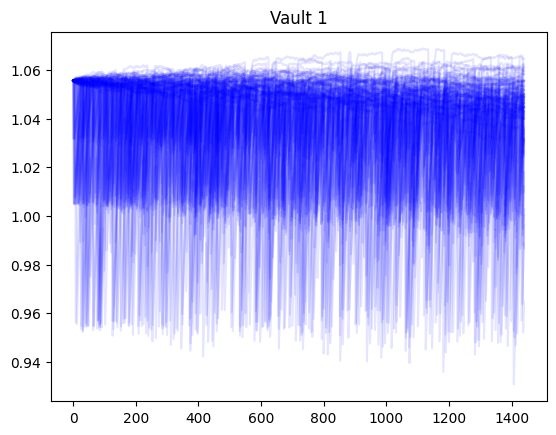

In [129]:
idx = 0
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

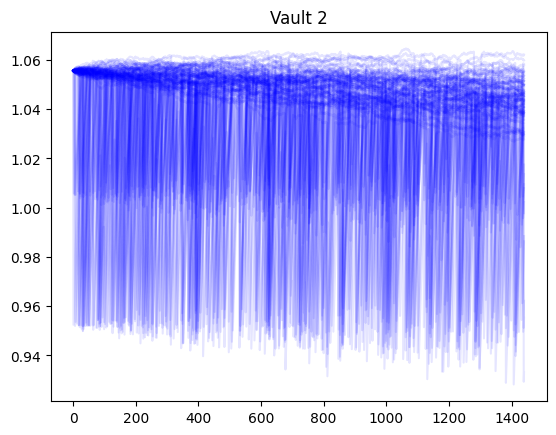

In [130]:
idx = 1
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

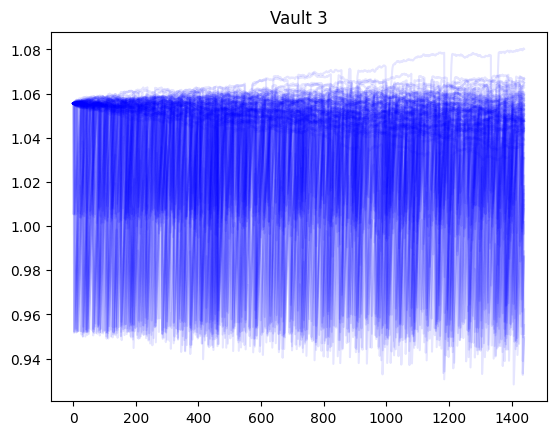

In [131]:
idx = 2
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

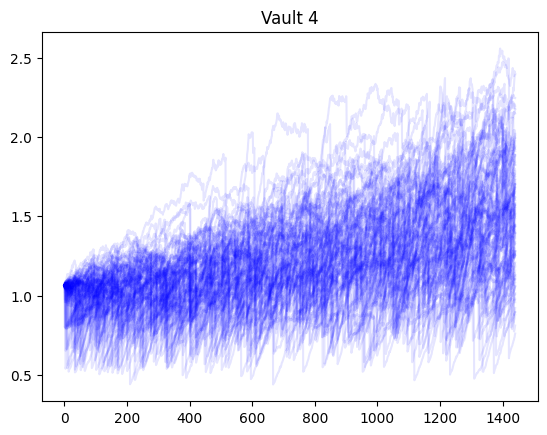

In [132]:
idx = 3
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

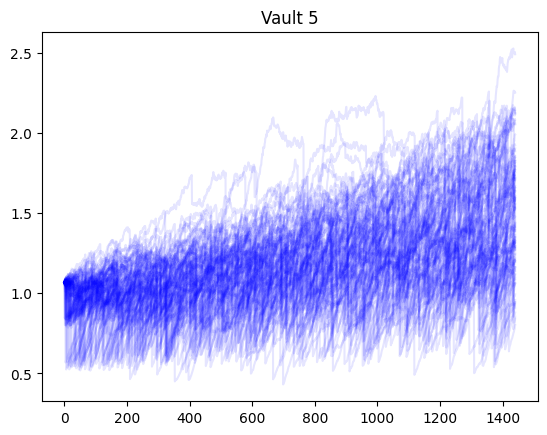

In [133]:
idx = 4
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

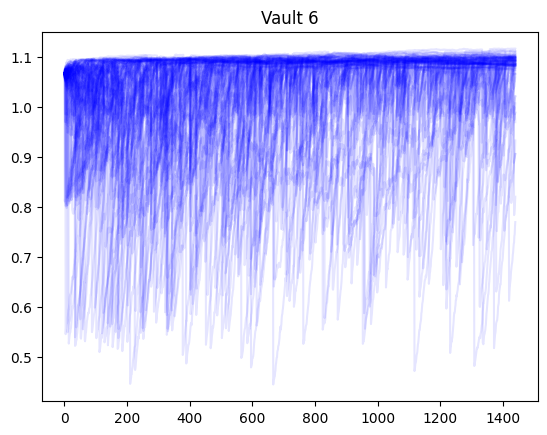

In [134]:
idx = 5
plt.title(f'Vault {idx + 1}')
tmp = np.vstack([f[idx].reshape((1, -1)) for f in health_factors])
plt.plot(tmp, color='blue', alpha=0.1);

In [135]:
price_feed = PriceFeed(
    means,
    covariations,
    starting_values,
    jumps,
    jump_probs,
    jump_recoveries,
    10 ** 5,
)

emulation = Emulation(
    vaults,
    price_feed,
    np.zeros(len(vaults), dtype='float32'),
    .01 / 365 / 24,
    .1,
    .1,
)

In [ ]:
for _ in range(400):
    emulation.next_step()
    emulation.liquidate()
    emulation.check_undercollateralized()

In [ ]:
idx = 0
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 1
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 2
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 3
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 4
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 5
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 6
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 7
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();

In [ ]:
idx = 8
plt.title(f'Vault {idx + 1} loss')
plt.hist(emulation.losses[idx], color='lightblue', alpha=.5, edgecolor='black')
q = np.quantile(emulation.losses[idx], .99)
plt.axvline(q, label=f'VaR 0.1% = {round(q)}$', linestyle='--', color='red')
plt.legend();